# グラフ描画用

## import

In [1]:
import numpy as np
import scipy.linalg
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbars
import matplotlib.gridspec as gridspec
import datetime
import os
import time
import pathlib
import pickle
import sys
import uncertainties
from uncertainties import ufloat

import ising_model as ising

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['mathtext.fontset'] = 'cm'

## spectral gap 実験

### 定数

In [2]:
n_spin_min = 3
n_spin_max = 9
beta_list = [1e-1, 1e0, 2e0, 5e0, 1e1]
print()

### データのロード

axis=0: 逆温度, axis=1: サイト数, axis=2: 提案, axis=3: インスタンス

In [3]:
n_spin_list = np.arange(n_spin_min, n_spin_max+1)

# データ取得
i = 0
for beta in beta_list:
	j = 0
	for n_spin in n_spin_list:
		if j == 0:
			gap_data_beta = np.load("result/spectral_gap/{0}_sites/beta_{1}.npy".format(n_spin, '{:.0e}'.format(beta_list[i])))[np.newaxis]
		else:
			gap_data_beta = np.concatenate([gap_data_beta, np.load("result/spectral_gap/{0}_sites/beta_{1}.npy".format(n_spin, '{:.0e}'.format(beta_list[i])))[np.newaxis]])
		j += 1

	if i == 0:
		gap_data = gap_data_beta[np.newaxis]
	else:
		gap_data = np.concatenate([gap_data, gap_data_beta[np.newaxis]])
 
	i += 1
 
# 形状確認
print(gap_data.shape)

(5, 7, 5, 100)


### 計算

In [4]:
mean_gap_data = np.average(gap_data, axis=3)
std_gap_data = np.std(gap_data, axis=3)

print(mean_gap_data.shape)
print(std_gap_data.shape)

# 近似曲線計算
def exp_func(x, a):
    return 2**(-a*x)

def exp_func_2(x, a, b):
    return 2**(-a * (x+b) )

def exp_fit(x_data, y_data, y_std):
    # maxfev：関数の呼び出しの最大数, check_finite：Trueの場合NaNが含まれている場合はValueError発生
    # sigma : y_dataの標準偏差を入れることで、uncertaintyを計算できる？
    l_popt, l_pcov = curve_fit(exp_func, x_data, y_data, sigma=y_std, maxfev=10000, check_finite=False)
    return exp_func(x_data, *l_popt), l_popt, l_pcov

def exp_fit_2(x_data, y_data, y_std):
    # maxfev：関数の呼び出しの最大数, check_finite：Trueの場合NaNが含まれている場合はValueError発生
    # sigma : y_dataの標準偏差を入れることで、uncertaintyを計算できる？
    l_popt, l_pcov = curve_fit(exp_func_2, x_data, y_data, sigma=y_std, maxfev=10000, check_finite=False)
    return exp_func_2(x_data, *l_popt), l_popt, l_pcov

(5, 7, 5)
(5, 7, 5)


### plot

(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)
(7,) (7,)


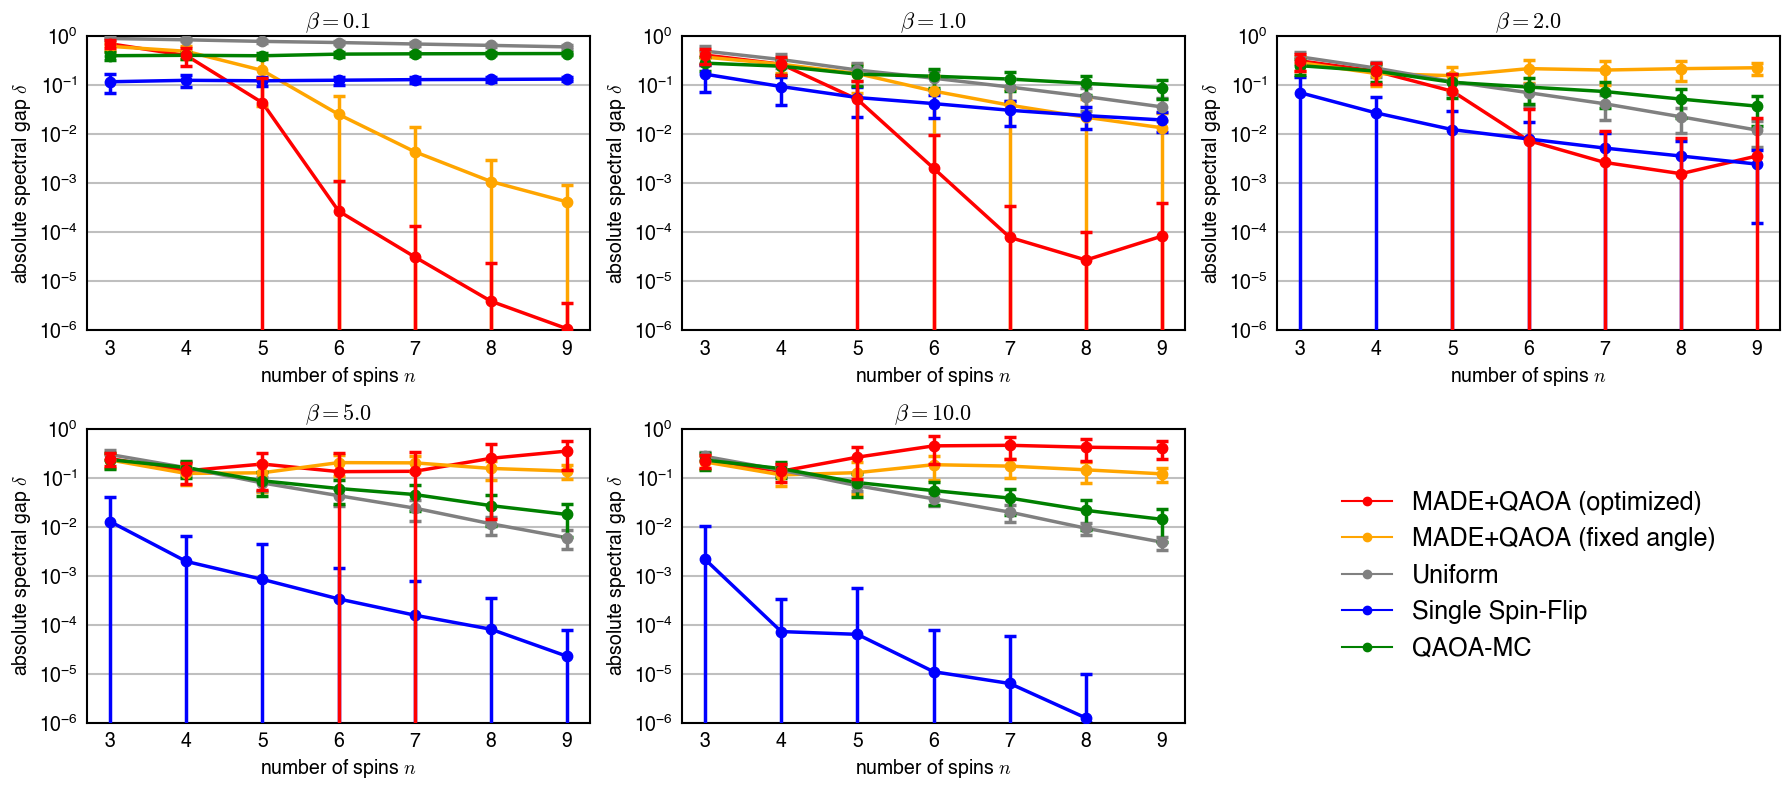

In [5]:
n_row = 2
n_col = 3

capsize = 4
markersize = 7.5
elinewidth = 2.5
capthick = 2.5
linewidth = 2.5

fig1, ax1 = plt.subplots(n_row, n_col, figsize=(18,8), dpi=100)

for i in range(len(beta_list)):
	row = i // n_col
	col = i % n_col
	
	print(n_spin_list.shape, mean_gap_data[i,:,0].shape)
	ax1[row,col].errorbar(n_spin_list, mean_gap_data[i,:,0], std_gap_data[i,:,0], color='red', linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='MADE+QAOA (optimized)', zorder=5)
	ax1[row,col].errorbar(n_spin_list, mean_gap_data[i,:,1], std_gap_data[i,:,1], color='orange', linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='MADE+QAOA (fixed angle)', zorder=4)
	ax1[row,col].errorbar(n_spin_list, mean_gap_data[i,:,2], std_gap_data[i,:,2], color='grey', linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='Uniform,', zorder=4)
	ax1[row,col].errorbar(n_spin_list, mean_gap_data[i,:,3], std_gap_data[i,:,3], color='blue', linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='Single Spin-Flip', zorder=4)
	ax1[row,col].errorbar(n_spin_list, mean_gap_data[i,:,4], std_gap_data[i,:,4], color='green', linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='QAOA-MC', zorder=4)
	ax1[row,col].set_xticks(n_spin_list)
 
	ax1[row,col].plot(n_spin_list, mean_gap_data[i,:,0], color='red', linewidth=linewidth)
	ax1[row,col].plot(n_spin_list, mean_gap_data[i,:,1], color='orange', linewidth=linewidth)
	ax1[row,col].plot(n_spin_list, mean_gap_data[i,:,2], color='grey', linewidth=linewidth)
	ax1[row,col].plot(n_spin_list, mean_gap_data[i,:,3], color='blue', linewidth=linewidth)
	ax1[row,col].plot(n_spin_list, mean_gap_data[i,:,4], color='green', linewidth=linewidth)
	ax1[row,col].grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=1.5)
 
	ax1[row,col].set_axisbelow(True) #gridを背面にする

	spines = 1.5
	ax1[row,col].spines["top"].set_linewidth(spines)
	ax1[row,col].spines["left"].set_linewidth(spines)
	ax1[row,col].spines["bottom"].set_linewidth(spines)
	ax1[row,col].spines["right"].set_linewidth(spines)
	
	ax1[row,col].set_yscale("log")
	ax1[row,col].set_ylim(1e-6, 1e0)
	ax1[row,col].set_xlabel(r'number of spins $n$', fontsize=14)
	ax1[row,col].set_ylabel(r'absolute spectral gap $\delta$', fontsize=14)
	ax1[row,col].tick_params(width=0.0, labelsize=14)
	ax1[row,col].minorticks_off()
	ax1[row,col].set_title(r'$\beta={0}$'.format(beta_list[i]),{"fontsize": 16})

	#if i == len(beta_list)-1:
		#ax1[row,col].legend(fontsize=14, bbox_to_anchor=(1.2, 1.0))
  
ax1[-1,-1].plot([], [], marker='o', color='red', label='MADE+QAOA (optimized)', linestyle=None)
ax1[-1,-1].plot([], [], marker='o', color='orange', label='MADE+QAOA (fixed angle)', linestyle=None)
ax1[-1,-1].plot([], [], marker='o', color='grey', label='Uniform', linestyle=None)
ax1[-1,-1].plot([], [], marker='o', color='blue', label='Single Spin-Flip', linestyle=None)
ax1[-1,-1].plot([], [], marker='o', color='green', label='QAOA-MC', linestyle=None)

for spine in ax1[-1,-1].spines.values():
    spine.set_visible(False)
ax1[-1,-1].axes.get_xaxis().set_visible(False)
ax1[-1,-1].axes.get_yaxis().set_visible(False)

ax1[-1,-1].legend(fontsize=18, bbox_to_anchor=(0.5,0.5), loc='center', frameon=False)

plt.tight_layout()
#fig1.savefig("ave_gap_vs_qubit.svg", dpi=300)
#fig1.savefig("ave_gap_vs_qubit.png", dpi=300)

### スケーリング

In [6]:
qaoa_mc_coef, qaoa_mc_cov = exp_fit_2(n_spin_list, mean_gap_data[i,:,4], std_gap_data[i,:,4])[1:3]
qaoa_mc_fit = exp_func_2(n_spin_list, qaoa_mc_coef[0], qaoa_mc_coef[1])

uni_coef, uni_cov = exp_fit(n_spin_list, mean_gap_data[i,:,2], std_gap_data[i,:,2])[1:3]
uni_fit = exp_func(n_spin_list, uni_coef[0])

qaoa_mc_uc = np.diag(np.sqrt(qaoa_mc_cov))
uni_uc = np.diag(np.sqrt(uni_cov))

u_qaoa_mc_coef = ufloat(qaoa_mc_coef[0], qaoa_mc_uc[0])
u_uni_coef = ufloat(uni_coef[0], uni_uc[0])

print("QAOA-MC : y = 2 ** (- {0} * (n + {1}) )".format(qaoa_mc_coef[0], qaoa_mc_coef[1]))
print("scaling factor(uncertainty) : k = {0}".format(u_qaoa_mc_coef))

print("Uniform : y = 2 ** (- {0} * n)".format(uni_coef[0]))
print("scaling factor(uncertainty) : k = {0}".format(u_uni_coef))

QAOA-MC : y = 2 ** (- 0.6768982500065621 * (n + 0.14238347967278628) )
scaling factor(uncertainty) : k = 0.677+/-0.022
Uniform : y = 2 ** (- 0.8182173366973258 * n)
scaling factor(uncertainty) : k = 0.818+/-0.022


/var/folders/5z/hnd7blsn33vdfn4r3xgj5_sh0000gn/T/ipykernel_9450/2277429790.py:7: RuntimeWarning: invalid value encountered in sqrt
  qaoa_mc_uc = np.diag(np.sqrt(qaoa_mc_cov))


## MCMCシミュレーション実験

### 定数

In [7]:
n_spin = 20
beta = 2.5

### データのロード

In [8]:
data_folder_name = 'result/mcmc_simulation/{0}_sites_result/'.format(n_spin)

# データ取得
opt_qaoa_made_result = np.load(data_folder_name+"opt_qaoa_made_result.npy")
fix_qaoa_made_result = np.load(data_folder_name+"fix_qaoa_made_result.npy")
uniform_result = np.load(data_folder_name+"uniform_result.npy")
ssf_result = np.load(data_folder_name+"ssf_result.npy")

# インスタンス取得
source_dir_name = 'data'
fname_in = pathlib.Path(source_dir_name).joinpath('{0}_sites_instance.pickle'.format(n_spin))
with open(str(fname_in), 'rb') as f:
	instance = pickle.load(f)
 
# 形状確認
print(opt_qaoa_made_result.shape)

(10, 10001, 20)


### 磁化推定

In [10]:
n_chain = opt_qaoa_made_result.shape[0]
n_step = 10000

temp = np.arange(1, opt_qaoa_made_result.shape[1]+1)
normalize = np.tile(temp, (n_chain, 1))

# 平均磁化 (理論値)
#boltzmann_dist = ising.spin_boltzmann_distribution(instance, beta)
#true_val = ising.boltzmann_average_magnetization(n_spin, boltzmann_dist)
#print(true_val)
true_val = 0.0

# 平均磁化
opt_qaoa_made_mag = np.average(opt_qaoa_made_result, axis=2)
opt_qaoa_made_mag_hist = np.cumsum(opt_qaoa_made_mag, axis=1) / normalize
opt_qaoa_made_mag_mean = np.average(opt_qaoa_made_mag_hist, axis=0)[0:n_step+1]
opt_qaoa_made_mag_std = np.std(opt_qaoa_made_mag_hist, axis=0, ddof=1)[0:n_step+1]

fix_qaoa_made_mag = np.average(fix_qaoa_made_result, axis=2)
fix_qaoa_made_mag_hist = np.cumsum(fix_qaoa_made_mag, axis=1) / normalize
fix_qaoa_made_mag_mean = np.average(fix_qaoa_made_mag_hist, axis=0)[0:n_step+1]
fix_qaoa_made_mag_std = np.std(fix_qaoa_made_mag_hist, axis=0, ddof=1)[0:n_step+1]

uniform_mag = np.average(uniform_result, axis=2)
uniform_mag_hist = np.cumsum(uniform_mag, axis=1) / normalize
uniform_mag_mean = np.average(uniform_mag_hist, axis=0)[0:n_step+1]
uniform_mag_std = np.std(uniform_mag_hist, axis=0, ddof=1)[0:n_step+1]

ssf_mag = np.average(ssf_result, axis=2)
ssf_mag_hist = np.cumsum(ssf_mag, axis=1) / normalize
ssf_mag_mean = np.average(ssf_mag_hist, axis=0)[0:n_step+1]
ssf_mag_std = np.std(ssf_mag_hist, axis=0, ddof=1)[0:n_step+1]

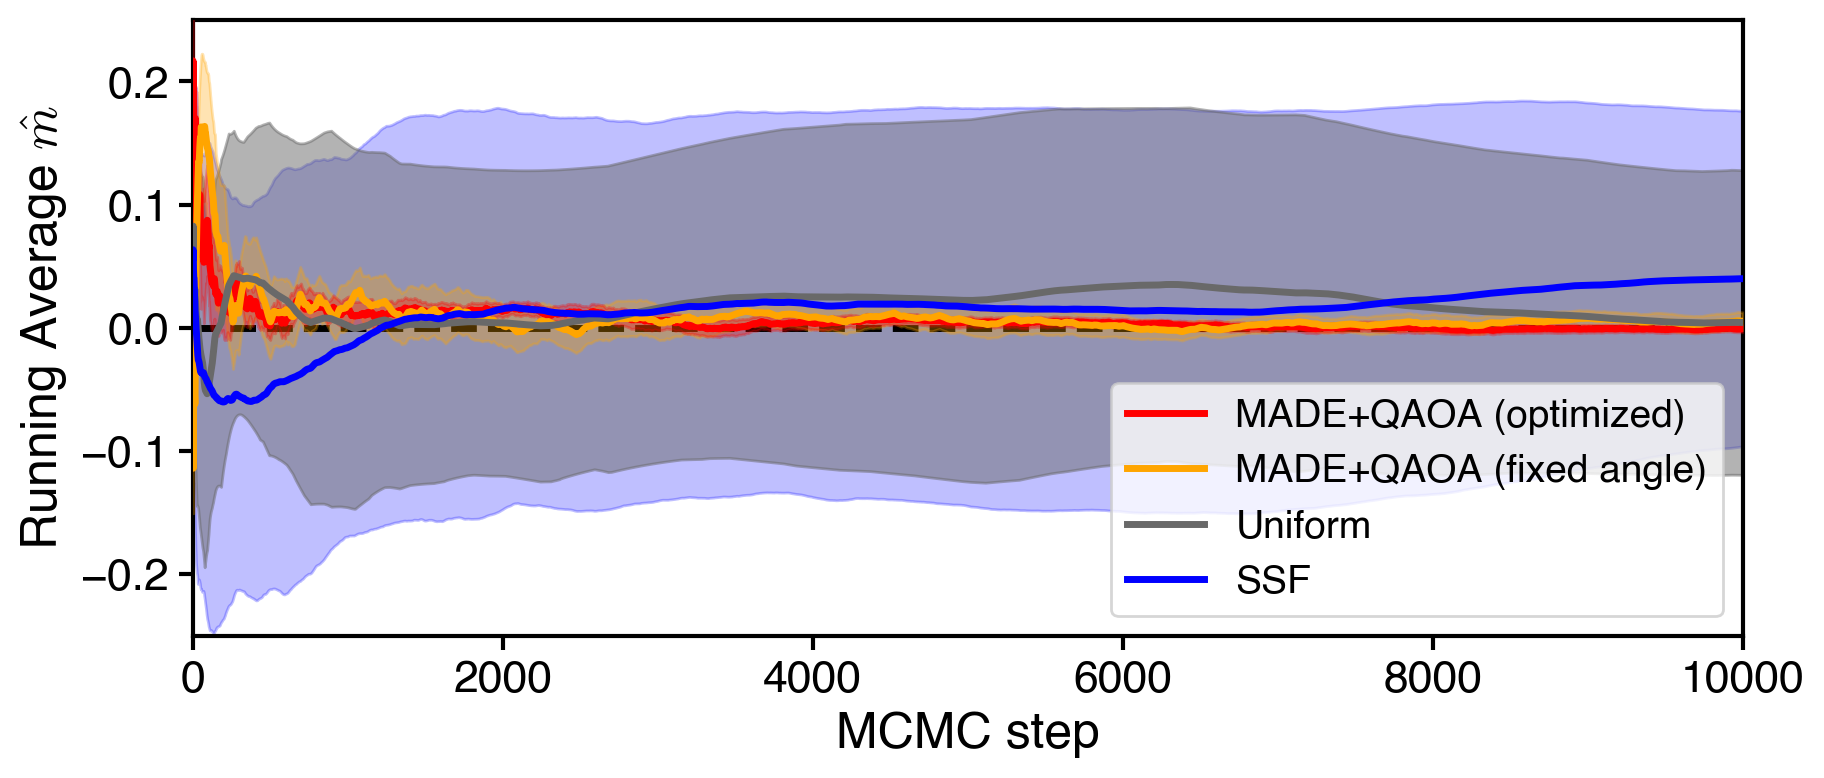

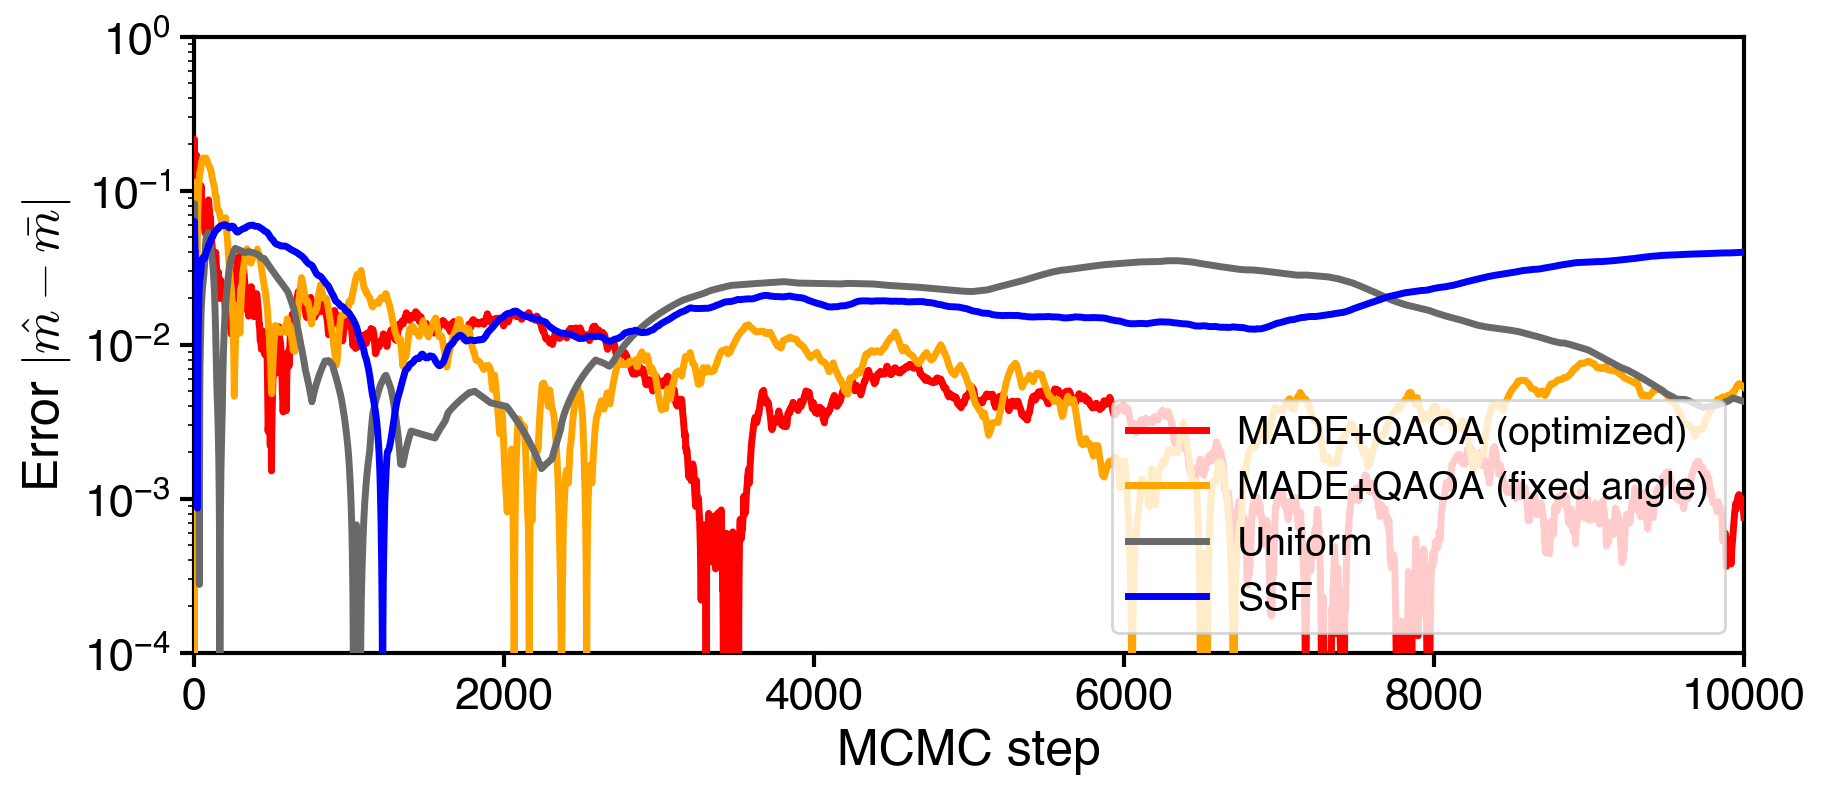

In [11]:
capsize = 4
markersize = 7.5
elinewidth = 2.5
capthick = 2.5
linewidth = 2.5
spines = 1.5

fig2, ax2 = plt.subplots(figsize=(10,4), dpi=200)

ax2.spines["top"].set_linewidth(spines)
ax2.spines["left"].set_linewidth(spines)
ax2.spines["bottom"].set_linewidth(spines)
ax2.spines["right"].set_linewidth(spines)

ax2.plot(np.arange(n_step+1), opt_qaoa_made_mag_mean, color='red', linewidth=linewidth, label='MADE+QAOA (optimized)', zorder=5)
ax2.fill_between(np.arange(n_step+1), opt_qaoa_made_mag_mean+opt_qaoa_made_mag_std, opt_qaoa_made_mag_mean-opt_qaoa_made_mag_std, color='red', alpha=0.3, zorder=4)

ax2.plot(np.arange(n_step+1), fix_qaoa_made_mag_mean, color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)', zorder=5)
ax2.fill_between(np.arange(n_step+1), fix_qaoa_made_mag_mean+fix_qaoa_made_mag_std, fix_qaoa_made_mag_mean-fix_qaoa_made_mag_std, color='orange', alpha=0.3, zorder=3)

ax2.plot(np.arange(n_step+1), uniform_mag_mean, color='dimgrey', linewidth=linewidth, label='Uniform', zorder=5)
ax2.fill_between(np.arange(n_step+1), uniform_mag_mean+uniform_mag_std, uniform_mag_mean-uniform_mag_std, color='dimgrey', alpha=0.5, zorder=2)

ax2.plot(np.arange(n_step+1), ssf_mag_mean, color='blue', linewidth=linewidth, label='SSF', zorder=5)
ax2.fill_between(np.arange(n_step+1), ssf_mag_mean+ssf_mag_std, ssf_mag_mean-ssf_mag_std, color='blue', alpha=0.25, zorder=1)

ax2.axhline(true_val, color='black', linestyle='--', linewidth=linewidth)

ax2.set_xlim(0, n_step)
ax2.set_ylim(-0.25,0.25)
ax2.set_xlabel('MCMC step', fontsize=18)
ax2.set_ylabel(r'Running Average $\hat{m}$', fontsize=18)
ax2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2.tick_params(axis="x", which='major', width=1.5)
ax2.legend(fontsize=14, loc='lower right', frameon=True)

fig2_2, ax2_2 = plt.subplots(figsize=(10,4), dpi=200)

ax2_2.spines["top"].set_linewidth(spines)
ax2_2.spines["left"].set_linewidth(spines)
ax2_2.spines["bottom"].set_linewidth(spines)
ax2_2.spines["right"].set_linewidth(spines)

ax2_2.plot(np.arange(n_step+1), np.abs(opt_qaoa_made_mag_mean-true_val), color='red', linewidth=linewidth, label='MADE+QAOA (optimized)', zorder=5)
ax2_2.plot(np.arange(n_step+1), np.abs(fix_qaoa_made_mag_mean-true_val), color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)', zorder=5)
ax2_2.plot(np.arange(n_step+1), np.abs(uniform_mag_mean-true_val), color='dimgrey', linewidth=linewidth, label='Uniform', zorder=5)
ax2_2.plot(np.arange(n_step+1), np.abs(ssf_mag_mean-true_val), color='blue', linewidth=linewidth, label='SSF', zorder=5)

ax2_2.set_yscale('log')
ax2_2.set_xlim(0, n_step)
ax2_2.set_ylim(1e-4, 1e0)
ax2_2.set_xlabel('MCMC step', fontsize=18)
ax2_2.set_ylabel(r'Error $|\hat{m} - \bar{m}|$', fontsize=18)
ax2_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax2_2.tick_params(axis="x", which='major', width=1.5)
ax2_2.legend(fontsize=14, loc='lower right', frameon=True)

#fig2.savefig("mag_est_result.svg", bbox_inches='tight')

### エネルギー遷移

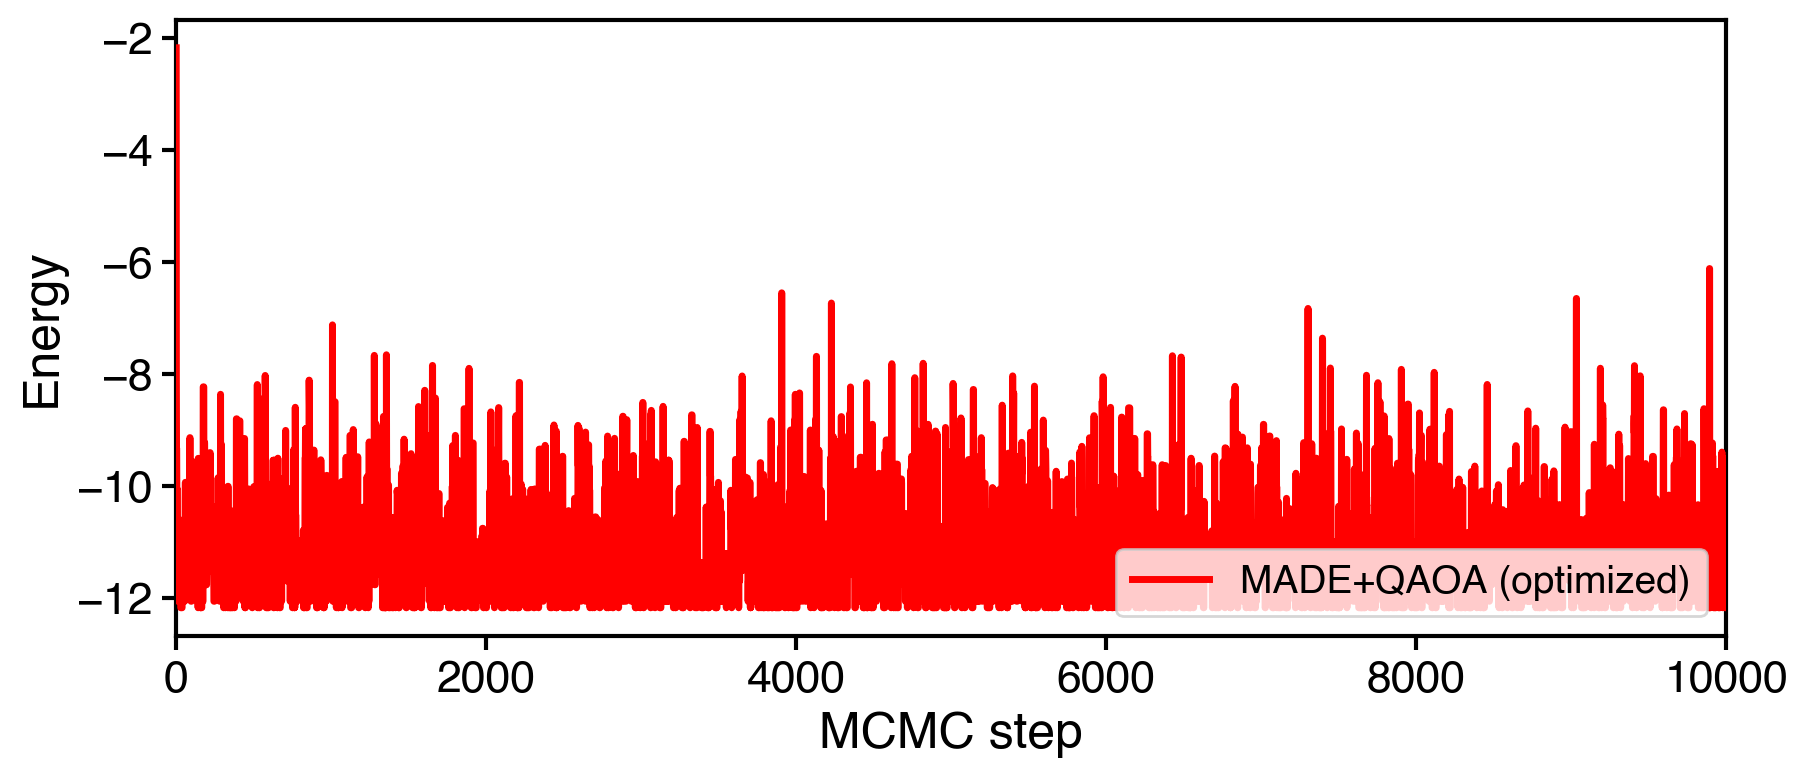

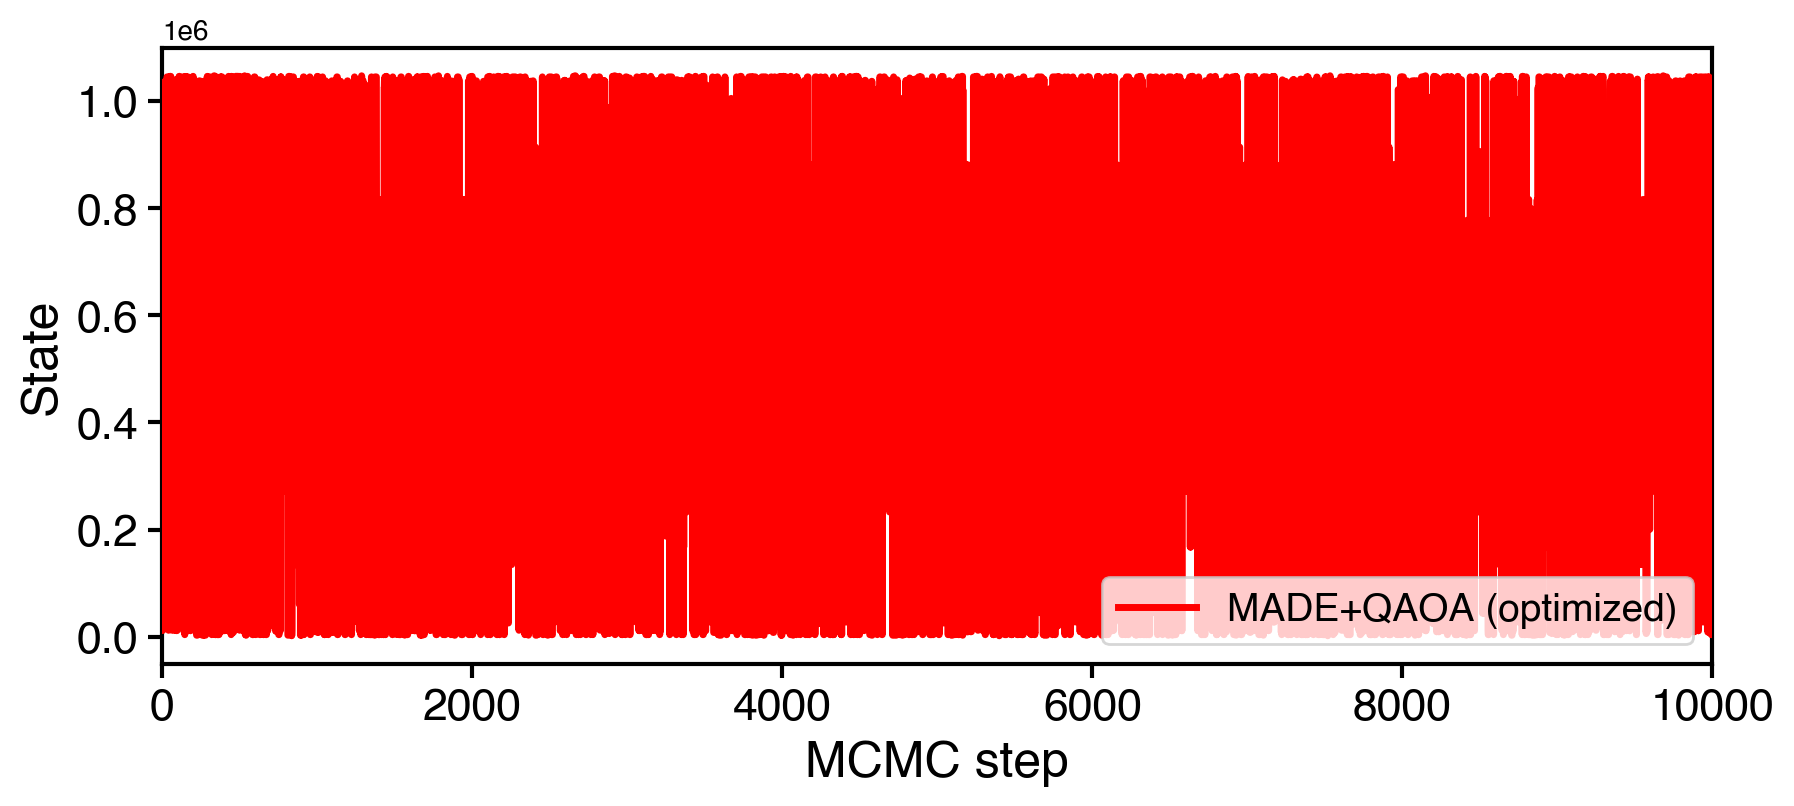

In [16]:
opt_energy_hist = np.array([ising.spin_energy(opt_qaoa_made_result[0,i], instance) for i in range(n_step+1)])
opt_state_hist = np.array([ising.spin_to_number(opt_qaoa_made_result[0,i]) for i in range(n_step+1)])

fig3_1, ax3_1 = plt.subplots(figsize=(10,4), dpi=200)

ax3_1.spines["top"].set_linewidth(spines)
ax3_1.spines["left"].set_linewidth(spines)
ax3_1.spines["bottom"].set_linewidth(spines)
ax3_1.spines["right"].set_linewidth(spines)

ax3_1.plot(np.arange(n_step+1), opt_energy_hist, color='red', linewidth=linewidth, label='MADE+QAOA (optimized)', zorder=5)

ax3_1.set_xlim(0, n_step)
ax3_1.set_xlabel('MCMC step', fontsize=18)
ax3_1.set_ylabel('Energy', fontsize=18)
ax3_1.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3_1.tick_params(axis="x", which='major', width=1.5)
ax3_1.legend(fontsize=14, loc='lower right', frameon=True)

fig3_2, ax3_2 = plt.subplots(figsize=(10,4), dpi=200)

ax3_2.spines["top"].set_linewidth(spines)
ax3_2.spines["left"].set_linewidth(spines)
ax3_2.spines["bottom"].set_linewidth(spines)
ax3_2.spines["right"].set_linewidth(spines)

ax3_2.plot(np.arange(n_step+1), opt_state_hist, color='red', linewidth=linewidth, label='MADE+QAOA (optimized)', zorder=5)

ax3_2.set_xlim(0, n_step)
ax3_2.set_xlabel('MCMC step', fontsize=18)
ax3_2.set_ylabel('State', fontsize=18)
ax3_2.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax3_2.tick_params(axis="x", which='major', width=1.5)
ax3_2.legend(fontsize=14, loc='lower right', frameon=True)

### エネルギー自己相関関数

In [13]:
def mcmc_energy_autocorrelation(spin_history, instance, lag):
	energy_history = np.array([[ising.spin_energy(spin_history[i,j], instance) for j in range(spin_history.shape[1])] for i in range(spin_history.shape[0])])
	energy_mean = np.tile(np.average(energy_history, axis=1).reshape((energy_history.shape[0],1)), (1,spin_history.shape[1]))
	energy_acf = np.zeros((spin_history.shape[0], lag))
    
	for j in range(lag):
		if j == 0:
			energy_acf[:,j] = 1.0
		else:
			n = spin_history.shape[1] - j
			energy_acf[:,j] = np.average((energy_history[:,:n] - energy_mean[:,:n]) * (energy_history[:,-n:] - energy_mean[:,:n]), axis=1)
			energy_acf[:,j] /= np.sqrt(np.average((energy_history[:,:n] - energy_mean[:,:n])**2, axis=1) * np.average((energy_history[:,-n:] - energy_mean[:,:n])**2, axis=1))
	
	return energy_acf

In [14]:
lag = 1000
energy_acf_history_opt_made = mcmc_energy_autocorrelation(opt_qaoa_made_result[:,1:], instance, lag)
energy_acf_history_fix_made = mcmc_energy_autocorrelation(fix_qaoa_made_result[:,1:], instance, lag)
energy_acf_history_uni = mcmc_energy_autocorrelation(uniform_result[:,1:], instance, lag)
energy_acf_history_ssf = mcmc_energy_autocorrelation(ssf_result[:,1:], instance, lag)

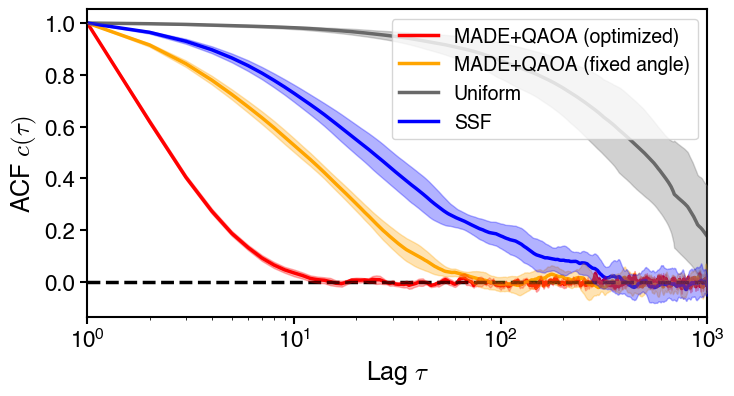

In [15]:
energy_acf_opt_made_ave = np.average(energy_acf_history_opt_made, axis=0)
energy_acf_opt_made_std = np.std(energy_acf_history_opt_made, axis=0)
energy_acf_fix_made_ave = np.average(energy_acf_history_fix_made, axis=0)
energy_acf_fix_made_std = np.std(energy_acf_history_fix_made, axis=0)
energy_acf_uni_ave = np.average(energy_acf_history_uni, axis=0)
energy_acf_uni_std = np.std(energy_acf_history_uni, axis=0)
energy_acf_ssf_ave = np.average(energy_acf_history_ssf, axis=0)
energy_acf_ssf_std = np.std(energy_acf_history_ssf, axis=0)

fig4, ax4 = plt.subplots(figsize=(8,4))

ax4.spines["top"].set_linewidth(spines)
ax4.spines["left"].set_linewidth(spines)
ax4.spines["bottom"].set_linewidth(spines)
ax4.spines["right"].set_linewidth(spines)

ax4.plot(np.arange(1, lag+1), energy_acf_opt_made_ave, color='red', linewidth=linewidth, label='MADE+QAOA (optimized)')
ax4.fill_between(np.arange(1, lag+1), energy_acf_opt_made_ave+energy_acf_opt_made_std, energy_acf_opt_made_ave-energy_acf_opt_made_std, color='red', alpha=0.3, zorder=4)
ax4.plot(np.arange(1, lag+1), energy_acf_fix_made_ave, color='orange', linewidth=linewidth, label='MADE+QAOA (fixed angle)')
ax4.fill_between(np.arange(1, lag+1), energy_acf_fix_made_ave+energy_acf_fix_made_std, energy_acf_fix_made_ave-energy_acf_fix_made_std, color='orange', alpha=0.3, zorder=4)
ax4.plot(np.arange(1, lag+1), energy_acf_uni_ave, color='dimgrey', linewidth=linewidth, label='Uniform')
ax4.fill_between(np.arange(1, lag+1), energy_acf_uni_ave+energy_acf_uni_std, energy_acf_uni_ave-energy_acf_uni_std, color='dimgrey', alpha=0.3, zorder=4)
ax4.plot(np.arange(1, lag+1), energy_acf_ssf_ave, color='blue', linewidth=linewidth, label='SSF')
ax4.fill_between(np.arange(1, lag+1), energy_acf_ssf_ave+energy_acf_ssf_std, energy_acf_ssf_ave-energy_acf_ssf_std, color='blue', alpha=0.3, zorder=4)

ax4.axhline(0.0, color='black', linestyle='--', linewidth=linewidth)

ax4.set_xlim(1, lag)
ax4.set_xscale('log')
ax4.set_xlabel(r'Lag $\tau$', fontsize=18)
ax4.set_ylabel(r'ACF $c(\tau)$', fontsize=18)
ax4.tick_params(width=1.5, labelsize=16, length=5, labelbottom=True)
ax4.tick_params(axis="x", which='major', width=1.5)
ax4.legend(fontsize=14, loc='upper right', frameon=True)